In [1]:
!pip install torch
!pip install numpy
!pip install gdown
!pip install pypianoroll
!pip install livelossplot
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.8 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=fd0b95af84fbb0be68d66a38774a7549d25c1b3b57e8ce1c6154bd172e4a0067
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


In [2]:
lpd_path = "/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed"
labeled_csv_path = "/kaggle/input/lpd-datasets/labeled_lpd.csv"

In [3]:
import csv
import pandas as pd
import numpy as np
from pypianoroll import Multitrack, Track, load
import tqdm

In [4]:
df = pd.read_csv(labeled_csv_path, skiprows=1, header=None, names=['Path', 'Valence', 'Energy'])


def calculate_quadrant(valence, energy):
    return 1 if valence < 0.5 and energy >= 0.5 else 2 if valence >= 0.5 and energy >= 0.5 else 3 if valence < 0.5 and energy < 0.5 else 4 

df['Path'] = df['Path'].apply(lambda x: x.replace('./data/lpd/lpd_cleansed', lpd_path))
df['Quadrant'] = df.apply(lambda row: calculate_quadrant(row['Valence'], row['Energy']), axis=1)
df = df.drop(['Valence', 'Energy'], axis=1)

quadrant_1_paths = df[df['Quadrant'] == 1]['Path'].tolist()
quadrant_2_paths = df[df['Quadrant'] == 2]['Path'].tolist()
quadrant_3_paths = df[df['Quadrant'] == 3]['Path'].tolist()
quadrant_4_paths = df[df['Quadrant'] == 4]['Path'].tolist()

print(quadrant_4_paths[:10])

dataset = quadrant_4_paths

['/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/D/B/TRDDBTV12903CDF740/061d13d33c186c90f137605644bf217d.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/D/S/TRDDSRI128F4262747/07e81fd29a2b0bc5516b89aaabb8c7a4.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/D/Q/TRDDQLH128F427DC24/f04e1262caacda0c529e9c5f983c077c.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/D/T/TRDDTKY128F92EF9B8/c56d4512f83f17ede130035312b221ae.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/D/V/TRDDVRY128F426C4A6/b10a1a42a5a9d26ddf4b1204e74ab238.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/D/L/TRDDLZS128F933F5B6/faf73d8929d8dafe55420f10fa94ed0e.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/B/V/TRDBVFN128F42699ED/23a132a4dc3d27769cc0a8bda15b54e4.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/B/G/TRDBGWE128F14A8EE7/5d3151a5f422e956bed2b2738ca7b75e.npz', '/kaggle/input/lakh5lpd/lpd_5/lpd_5_cleansed/D/K/F/TRDKFRL128F92FF4D1/0878d25820cba1a2622d5bcb2a525306.npz', '/kaggle/input/lak

In [5]:
import sys
import scipy.sparse as sp
import pypianoroll
from tqdm import tqdm
from pypianoroll import Multitrack, Track
import os
import matplotlib.pyplot as plt
import random
import torch

[StandardTrack(name='Drums', program=0, is_drum=True, pianoroll=array(shape=(9528, 128), dtype=uint8)), StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(9528, 128), dtype=uint8)), StandardTrack(name='Guitar', program=24, is_drum=False, pianoroll=array(shape=(9528, 128), dtype=uint8)), StandardTrack(name='Bass', program=32, is_drum=False, pianoroll=array(shape=(9528, 128), dtype=uint8)), StandardTrack(name='Strings', program=48, is_drum=False, pianoroll=array(shape=(9528, 128), dtype=uint8))]


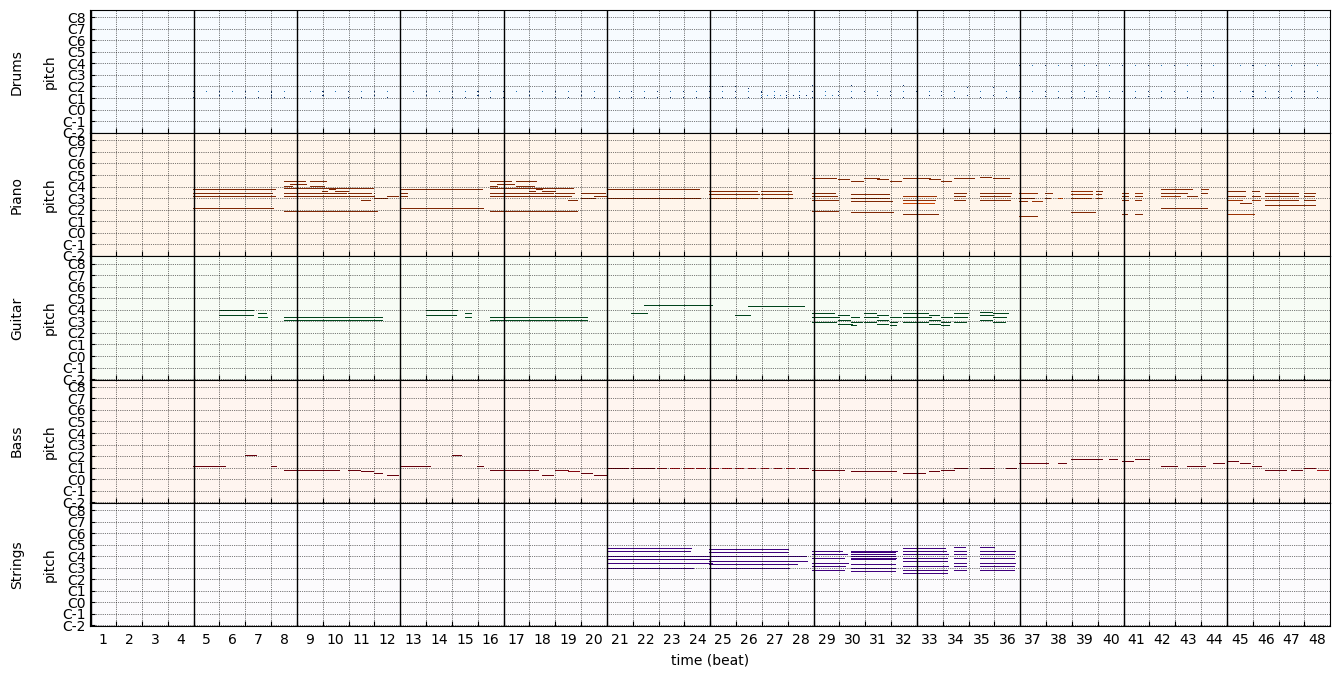

In [6]:
multitrack = pypianoroll.load(dataset[0])

print(multitrack.tracks)

for track in multitrack.tracks:
    if np.any(track.pianoroll):
        track.trim(end=12 * 96)

axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))

for ax in axs:
    for x in range(96, 12 * 96, 96):
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)

plt.show()

In [7]:
beat_resolution = 4
lowest_pitch = 24
n_pitches = 72
n_tracks = 5
n_measures = 4
measure_resolution = 4 * beat_resolution
n_samples_per_song = 8

data_quad = []
for file in dataset:
    multitrack = pypianoroll.load(file)
    multitrack.binarize()
    multitrack.set_resolution(beat_resolution)
    pianoroll = (multitrack.stack() > 0)
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data_quad.append(pianoroll[:, start:end])
random.shuffle(data_quad)
data_quad = np.stack(data_quad)
print(f"Successfully collect {len(data_quad)} samples from {len(dataset)} songs")
print(f"Data shape : {data_quad.shape}")

Successfully collect 3150 samples from 757 songs
Data shape : (3150, 5, 64, 72)


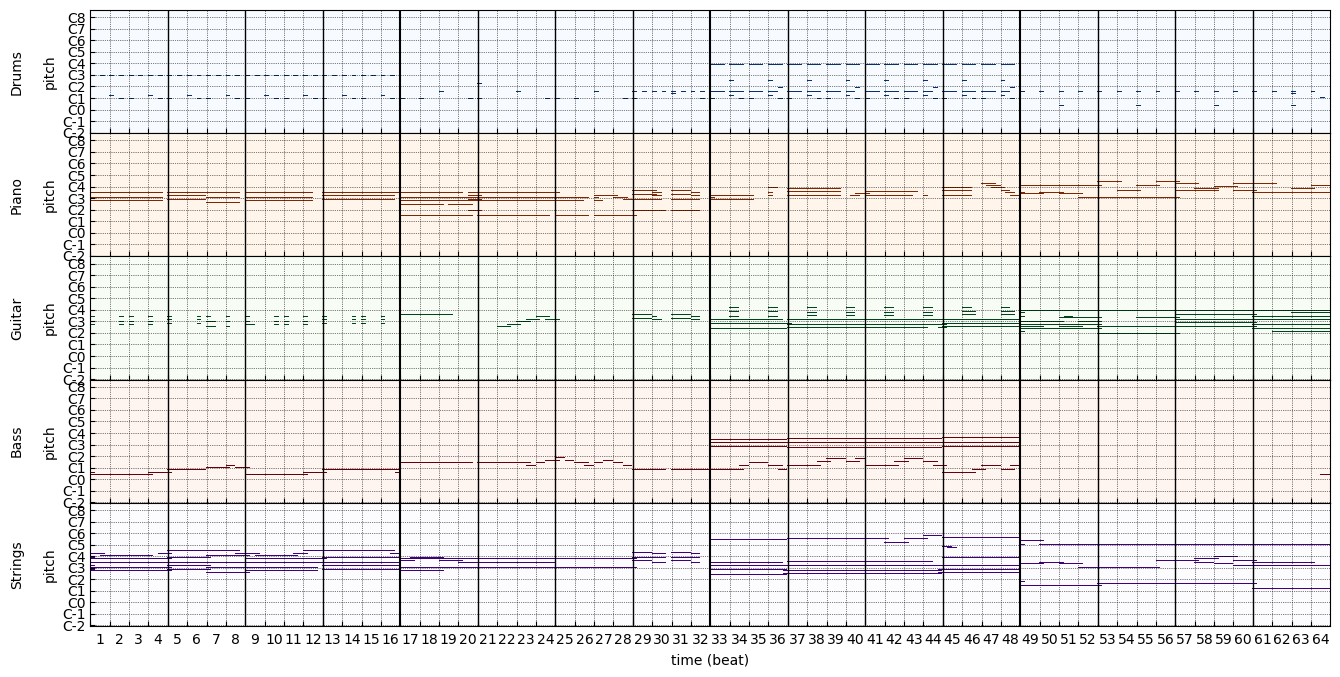

In [8]:
programs = [0, 0, 25, 33, 48]
is_drums = [True, False, False, False, False]
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings'] 
tempo = 100
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)

tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data_quad[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [9]:
batch_size = 16
latent_dim = 128
n_steps = 6000
data_quad = torch.as_tensor(data_quad, dtype=torch.float32)
dataset_quad = torch.utils.data.TensorDataset(data_quad)
dataloader_quad = torch.utils.data.DataLoader(
    dataset_quad, batch_size=batch_size, drop_last=True, shuffle=True
)

In [10]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [11]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneratorBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneratorBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneratorBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneratorBlock(64, 32, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneratorBlock(32, 16, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneratorBlock(16, 1, (1, 1, 12), (1, 1, 12))
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

In [12]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [13]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 5, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (3, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)          
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

In [15]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [16]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    latent = torch.randn(batch_size, latent_dim)
    
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()

    d_optimizer.zero_grad()
    prediction_real = discriminator(real_samples)
    d_loss_real = -torch.mean(prediction_real)
    d_loss_real.backward()
    

    fake_samples = generator(latent)
    prediction_fake_d = discriminator(fake_samples.detach())
    d_loss_fake = torch.mean(prediction_fake_d)
    d_loss_fake.backward()

    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data
    )
    gradient_penalty.backward()

    d_optimizer.step()
    
    g_optimizer.zero_grad()
    prediction_fake_g = discriminator(fake_samples)
    g_loss = -torch.mean(prediction_fake_g)
    g_loss.backward()
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

In [17]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

sample_interval = 100
n_samples = 4

discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

sample_latent = torch.randn(n_samples, latent_dim)

if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

history_samples = {}
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

step = 0

Number of parameters in G: 313951
Number of parameters in D: 204321


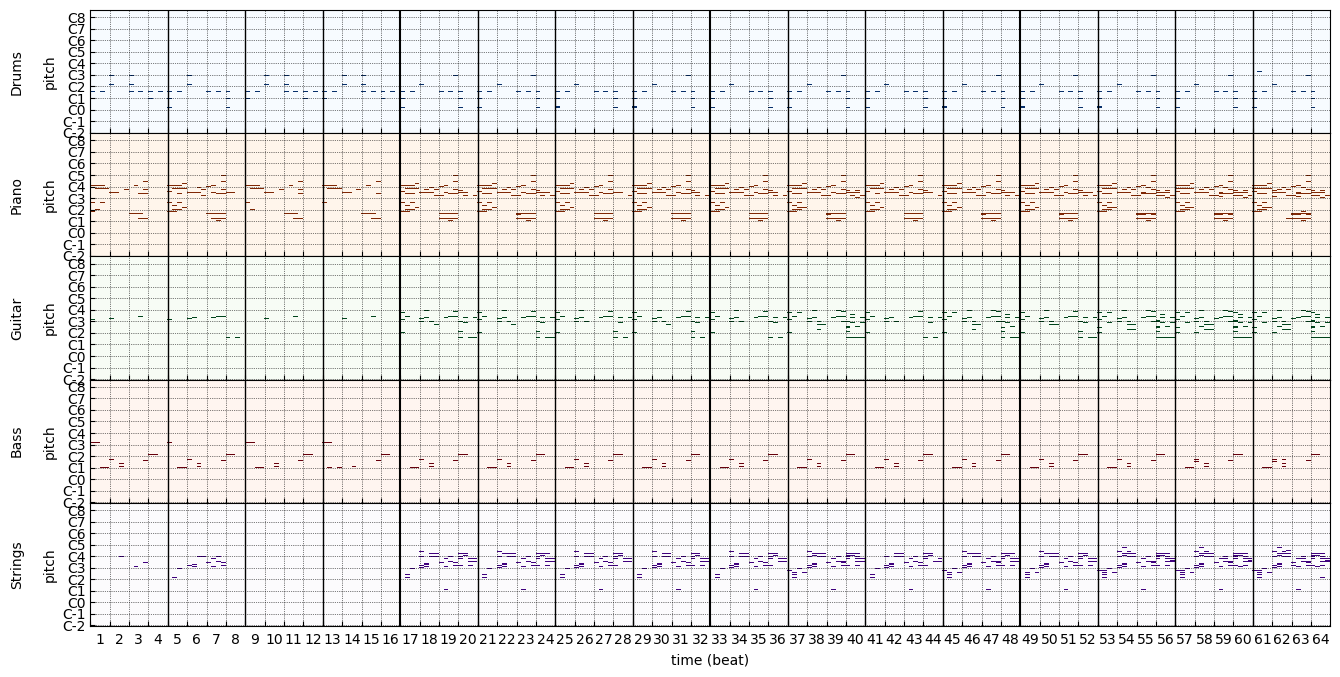

In [18]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

while step < n_steps + 1:
    for real_samples in dataloader_quad:
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0])

        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})

        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))

        if step % sample_interval == 0:
            generator.eval()
            samples = generator(sample_latent).detach().cpu().numpy()
            history_samples[step] = samples

            clear_output(True)
            
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(
                zip(programs, is_drums, track_names)
            ):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
                )
                tracks.append(
                    Track(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    measure_resolution,
                    4 * measure_resolution * n_measures,
                    measure_resolution
                ):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()

        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

In [19]:
PATH = "./q4_model.pt"

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optimizer_state_dict': g_optimizer.state_dict(),
            'discriminator_optimizer_state_dict': d_optimizer.state_dict(),
            }, PATH)

Step=0


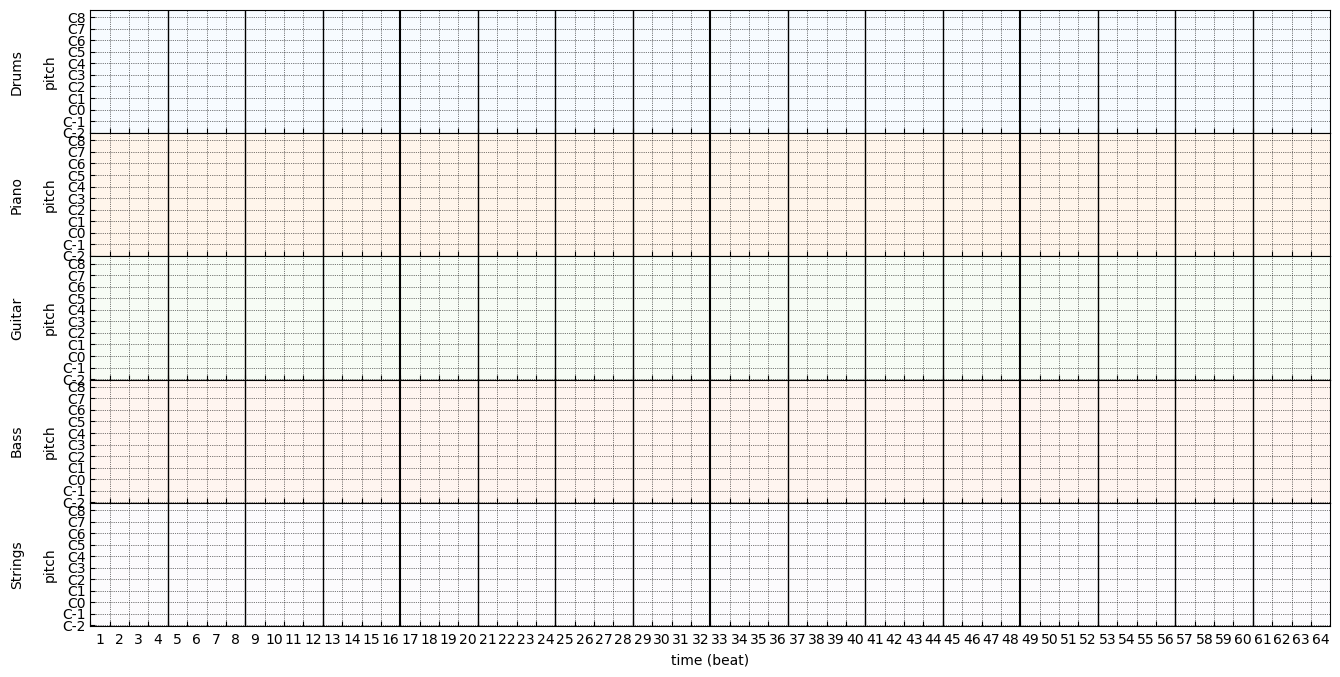

Step=100


(d_loss=-3.826799, g_loss= 15.780544): 6001it [12:41, 11.19it/s]                

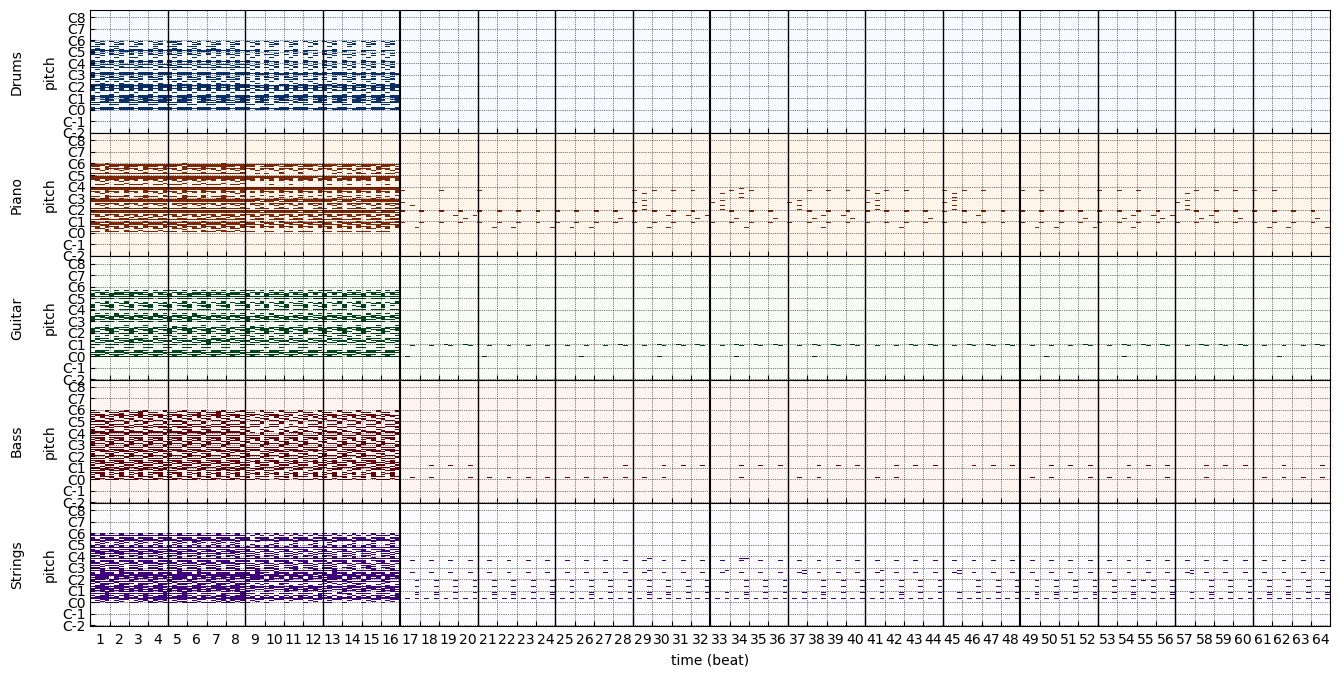

Step=1000


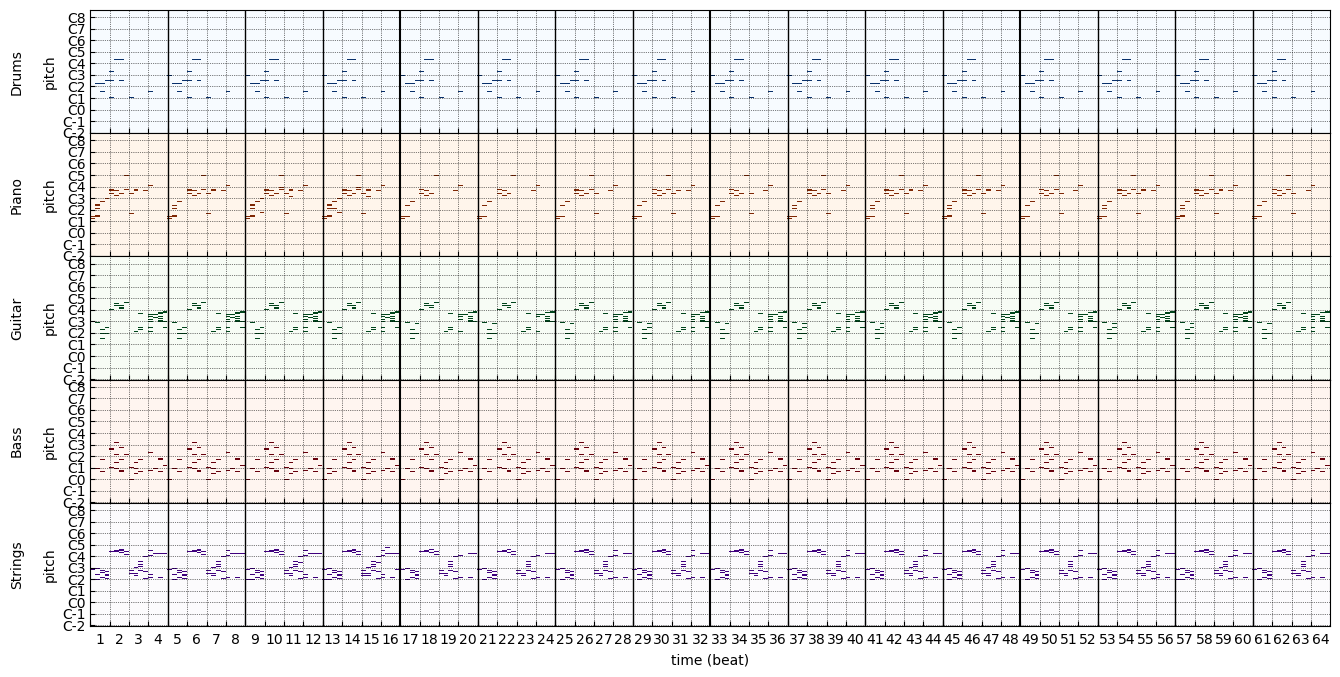

Step=5000


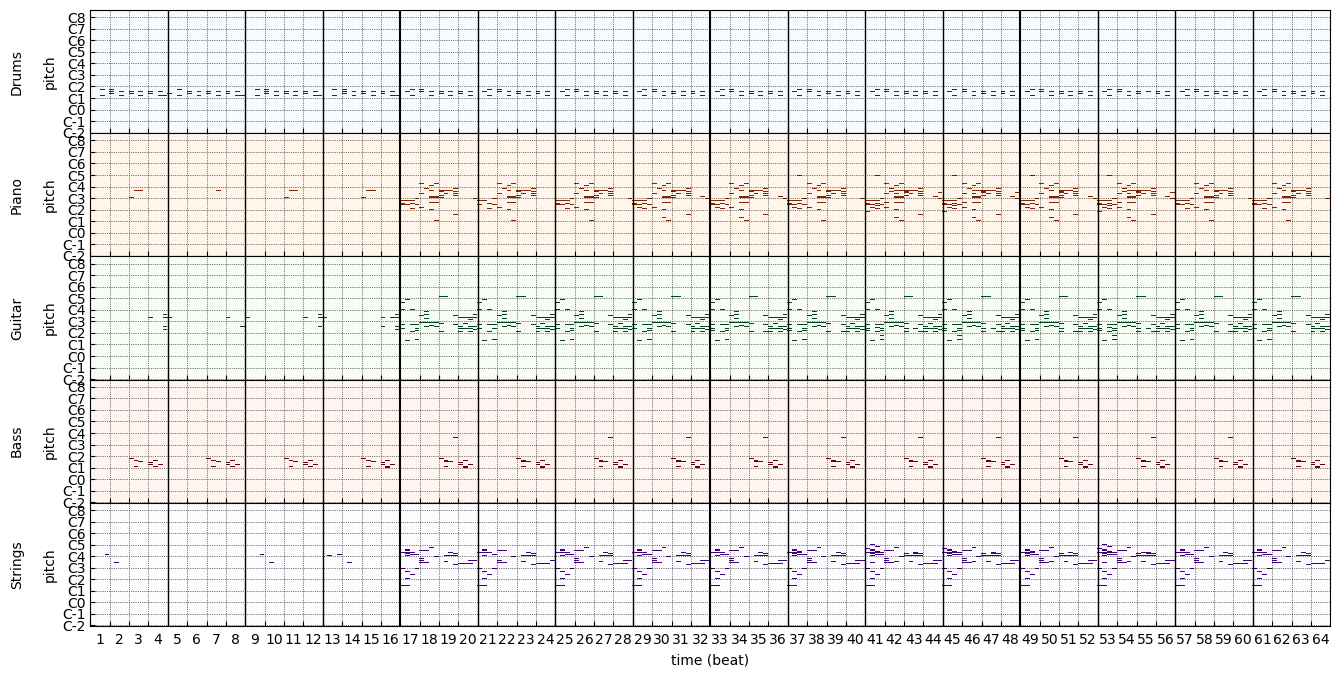

Step=6000


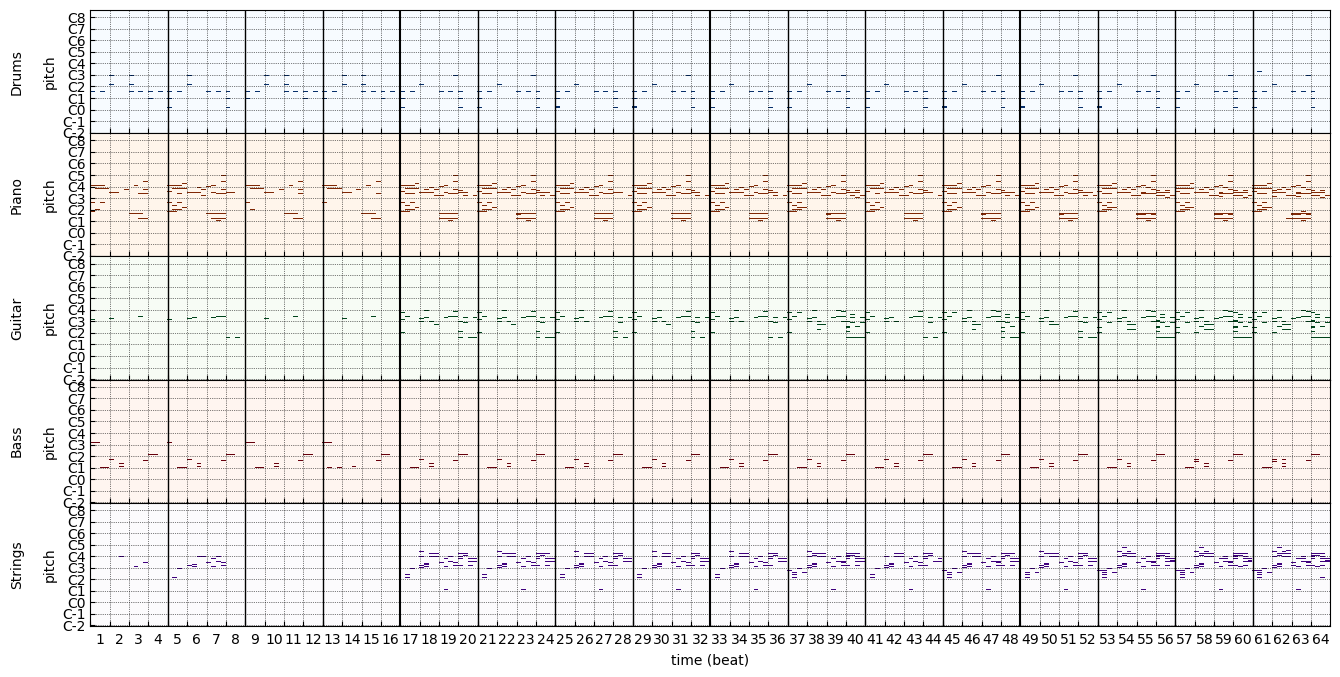

In [20]:
steps = [0, sample_interval, 10 * sample_interval, 50*sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
        tracks.append(
            Track(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.show()

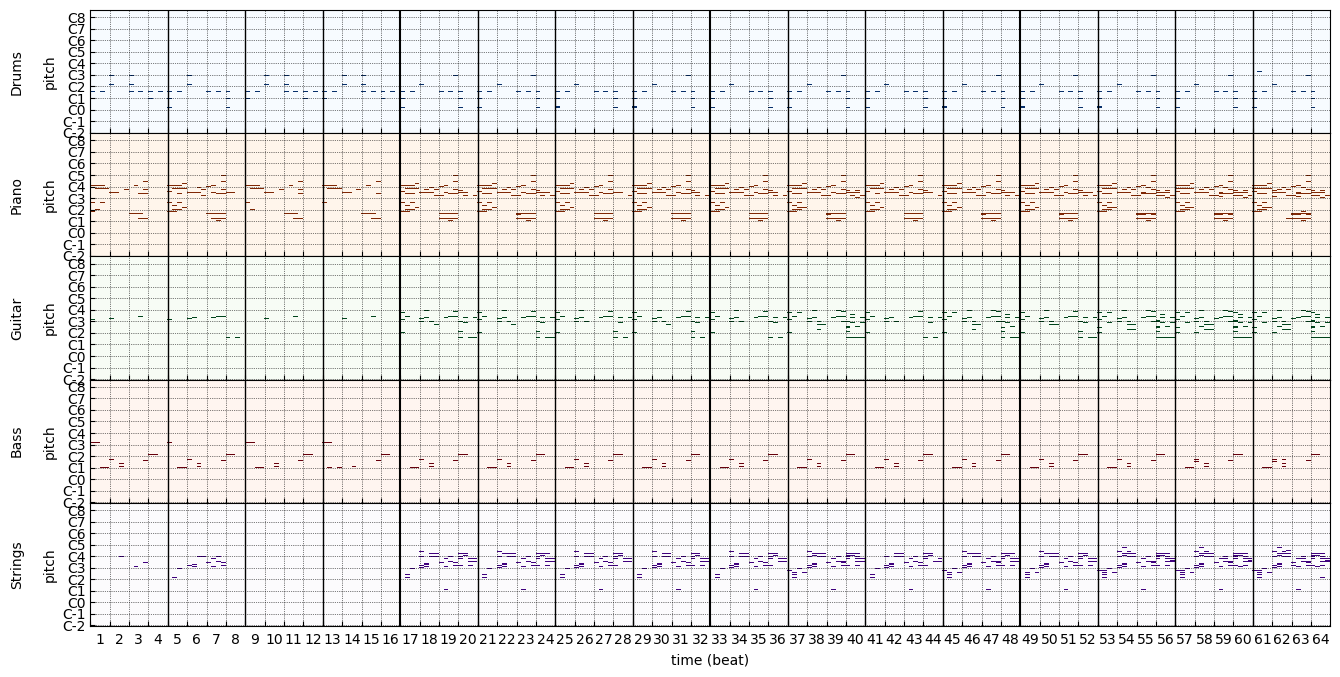

In [21]:
from pypianoroll import BinaryTrack
generator.eval()
samples = generator(sample_latent).detach().cpu().numpy()
samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        samples[idx] > 0.5,
        ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
    )
    tracks.append(
        BinaryTrack(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=pianoroll
        )
    )
m = Multitrack(
    tracks=tracks,
    tempo=tempo_array,
    resolution=beat_resolution
)

axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(
        measure_resolution,
        4 * measure_resolution * n_measures,
        measure_resolution
    ):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

# Convert Multitrack to PrettyMIDI
midi_music = m.to_pretty_midi()
midi_music.write("testing.mid")